In [2]:
import torch
import torchvision
import numpy as np
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision.utils as vutils
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.utils import save_image

from tqdm import tqdm
from easydict import EasyDict
import matplotlib.pyplot as plt

print(torch.__version__)

1.13.0


In [3]:
config = EasyDict({
    'INPUT_DIM' : 784,
    'HIDDEN_DIM': 200,
    'Z_DIM': 20,
    'LR': 1e-3,
    'BATCH_SIZE':100,
    'EPOCHS':30,
    'DEVICE': 'cuda' if torch.cuda.is_available else 'cpu'
})

print(config.DEVICE)

cuda


In [4]:

'''
References
- https://github.com/AntixK/PyTorch-VAE/blob/master/models/vanilla_vae.py
- https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/more_advanced/VAE/lightning_vae/model.py
'''

class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim):
        super().__init__()
        
        self.relu = nn.ReLU()

        # Encoder
        self.image_to_hidden = nn.Linear(input_dim, hidden_dim)
        self.hidden_to_mu = nn.Linear(hidden_dim, z_dim)
        self.hidden_to_sigma = nn.Linear(hidden_dim, z_dim)
        
        # Decoder
        self.z_to_hidden = nn.Linear(z_dim, hidden_dim)
        self.hidden_to_image = nn.Linear(hidden_dim, input_dim)
        
        
    def encode(self, x):
        h = self.relu(self.image_to_hidden(x))
        mu = self.hidden_to_mu(h)
        log_var = self.hidden_to_sigma(h)
        return mu, log_var # log variance로 학습하는 경우도 있음. -> Training stability
        
    def decode(self, z):
        h = self.relu(self.z_to_hidden(z))
        x_hat = torch.sigmoid(self.hidden_to_image(h)) # Why sigmoid? -> For reconstruction error. Normalized Our Data to 0~1. 
        return x_hat
    
    def reparametrization(self, mu, log_var):
        epsilon = torch.randn_like(log_var) # epsilon ~ N(0,I)
        sigma = torch.exp(0.5 * log_var)
        z_new = mu + sigma * epsilon.cuda() # 논문의 (10)식 - where ~ 부분 그대로 구현
        return z_new
    
    def forward(self, x):
        mu, log_var = self.encode(x) # x -> q_(phi)(z|x) -> mu, sigma
        z = self.reparametrization(mu, log_var) # (mu, sigma) -> z
        x_reconstructed = self.decode(z) # z -> p_(theta)(x|z) -> x'
        return x_reconstructed, mu, log_var


In [5]:
train_dataset = MNIST(root="dataset/", train=True, transform=transforms.ToTensor(), download=True)
test_dataset  = MNIST(root="dataset/", transform=transforms.ToTensor(), train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=config.BATCH_SIZE, 
                          shuffle=True, num_workers=4)
test_loader  = DataLoader(dataset=test_dataset, 
                          batch_size=config.BATCH_SIZE, 
                          shuffle=False)

model = VariationalAutoEncoder(input_dim = config.INPUT_DIM,
                             hidden_dim = config.HIDDEN_DIM,
                             z_dim = config.Z_DIM)
model.to(config.DEVICE)
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=config.LR)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [6]:
for epoch in range(config.EPOCHS):
    loop = tqdm(enumerate(train_loader))
    total_loss = 0
    for i, (x, _) in loop:
        x = x.to(config.DEVICE).view(x.shape[0],config.INPUT_DIM) # (batch_size, 1, 28, 28) -> (batch, 784)
        x_reconstructed, mu, log_var = model(x)
        
        # Reconstruction error
        reconstruction_loss = F.binary_cross_entropy(x_reconstructed, x, reduction='sum') # CE
#         reconstruction_loss = F.mse_loss(x_reconstructed, x,reduction='sum') # MSE

        # Regularization term (KL divergence)
        # [B, z_dim] -> sum(dim=1) -> [B] -> mean(dim=0) -> loss val
        # kld_loss = -torch.mean(0.5 * torch.sum(1 + torch.log(sigma**2) - mu**2 - sigma**2, dim=1), dim=0) # 논문의 10번 식 앞부분 그대로 
        kld_loss = -0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp()) # 논문의 10번 식 앞부분 그대로 


        loss = reconstruction_loss + kld_loss
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loop.set_postfix(loss=loss.item())
    
    print("Epoch: {}/{}".format(epoch + 1, config.EPOCHS), "\tAverage Loss: {:.6f}".format(total_loss / (i*config.BATCH_SIZE)))

      

600it [00:11, 51.84it/s, loss=1.29e+4]

Epoch: 1/30 	Average Loss: 173.362725



600it [00:09, 60.03it/s, loss=1.22e+4]

Epoch: 2/30 	Average Loss: 127.321421



600it [00:09, 63.32it/s, loss=1.16e+4]

Epoch: 3/30 	Average Loss: 118.813426



600it [00:09, 62.53it/s, loss=1.14e+4]

Epoch: 4/30 	Average Loss: 115.215049



600it [00:09, 63.78it/s, loss=1.12e+4]

Epoch: 5/30 	Average Loss: 113.050877



600it [00:09, 61.24it/s, loss=1.13e+4]

Epoch: 6/30 	Average Loss: 111.664536



600it [00:09, 62.27it/s, loss=1.05e+4]

Epoch: 7/30 	Average Loss: 110.740526



600it [00:09, 61.68it/s, loss=1.15e+4]

Epoch: 8/30 	Average Loss: 109.958355



600it [00:10, 59.76it/s, loss=1.08e+4]


Epoch: 9/30 	Average Loss: 109.367814


600it [00:09, 63.76it/s, loss=1.11e+4]

Epoch: 10/30 	Average Loss: 108.903636



600it [00:09, 62.88it/s, loss=1.12e+4]

Epoch: 11/30 	Average Loss: 108.485801



600it [00:09, 60.07it/s, loss=1.09e+4]

Epoch: 12/30 	Average Loss: 108.161673



600it [00:09, 63.52it/s, loss=1.06e+4]

Epoch: 13/30 	Average Loss: 107.870105



600it [00:09, 61.72it/s, loss=1.06e+4]

Epoch: 14/30 	Average Loss: 107.627196



600it [00:09, 61.32it/s, loss=1.09e+4]

Epoch: 15/30 	Average Loss: 107.385792



600it [00:09, 63.23it/s, loss=1.1e+4] 

Epoch: 16/30 	Average Loss: 107.165701



600it [00:09, 62.64it/s, loss=1.11e+4]

Epoch: 17/30 	Average Loss: 107.010091



600it [00:09, 62.73it/s, loss=1.04e+4]

Epoch: 18/30 	Average Loss: 106.815537



600it [00:10, 58.79it/s, loss=1.05e+4]

Epoch: 19/30 	Average Loss: 106.649283



600it [00:10, 59.23it/s, loss=1.09e+4]

Epoch: 20/30 	Average Loss: 106.538061



600it [00:09, 63.61it/s, loss=1.1e+4] 

Epoch: 21/30 	Average Loss: 106.361760



600it [00:10, 59.39it/s, loss=1.05e+4]

Epoch: 22/30 	Average Loss: 106.256512



600it [00:09, 61.57it/s, loss=1.08e+4]

Epoch: 23/30 	Average Loss: 106.154491



600it [00:09, 63.83it/s, loss=1.06e+4]

Epoch: 24/30 	Average Loss: 106.023748



600it [00:09, 61.99it/s, loss=1.08e+4]

Epoch: 25/30 	Average Loss: 105.888802



600it [00:09, 62.32it/s, loss=1.04e+4]

Epoch: 26/30 	Average Loss: 105.830117



600it [00:09, 63.95it/s, loss=1.05e+4]

Epoch: 27/30 	Average Loss: 105.731966



600it [00:09, 60.85it/s, loss=1.05e+4]

Epoch: 28/30 	Average Loss: 105.635860



600it [00:09, 63.74it/s, loss=1.05e+4]

Epoch: 29/30 	Average Loss: 105.521927



600it [00:09, 64.50it/s, loss=1.07e+4]

Epoch: 30/30 	Average Loss: 105.472989


# Image Generation

In [105]:
model.cuda()

VariationalAutoEncoder(
  (relu): ReLU()
  (image_to_hidden): Linear(in_features=784, out_features=200, bias=True)
  (hidden_to_mu): Linear(in_features=200, out_features=20, bias=True)
  (hidden_to_sigma): Linear(in_features=200, out_features=20, bias=True)
  (z_to_hidden): Linear(in_features=20, out_features=200, bias=True)
  (hidden_to_image): Linear(in_features=200, out_features=784, bias=True)
)

In [106]:
# Generate Images

def reparametrization(mu, log_var):
    epsilon = torch.randn_like(log_var) # epsilon ~ N(0,I)
    sigma = torch.exp(0.5 * log_var)
    z_new = mu + sigma * epsilon.cuda() # 논문의 (10)식 - where 부분 그대로 구현
    return z_new


with torch.no_grad():
    for batch_idx, (x, _) in enumerate(test_loader): ## Test Images
        x = x.view(config.BATCH_SIZE, config.INPUT_DIM)
        x = x.to(config.DEVICE)

        phi = model.encode(x)
        mu, log_var = phi[0], phi[1]
        z_new = reparametrization(mu, log_var)
        x_generated = model.decode(z_new)

        break

Text(0.5, 1.0, 'Generated Samples')

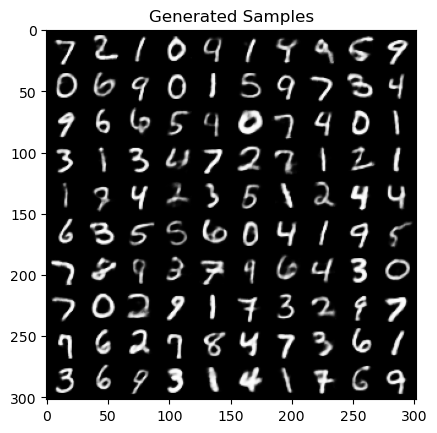

In [112]:
plt.imshow(torchvision.utils.make_grid(x_generated.view(-1,1,28,28).detach().cpu(), nrow=10).permute(1,2,0))
plt.title('Generated Samples')